In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, make_scorer, recall_score, fbeta_score, precision_score, roc_auc_score

import pickle

# Securing Investments: Machine Learning for Company Bankruptcy Forecasting

### Content


1.  Problem Definition and Goal Setting<br>
2. Data Collection and Exploration<br>
3. Data Preprocessing and Feature Selection<br>
4. Model<br>
4.1 Model Selection - Logistic Regression<br>
4.2 Model Training<br>
4.3 Model Evaluation<br>
4.4 Model Optimization<br>
    4.4.1 Feature Selection<br>
    4.4.2 Outlier removal<br>
    4.4.3 Class Weighting<br>
    4.4.4 Oversampling of the minority class<br>
4.5 Model Selection - Pipeline<br>
5. Model Comparison and Selection<br>
6. Final Model Testing<br>
7. Final Thoughts and Future Work<br>

## 1. Problem Definition and Goal Setting:

#### Problem Definition:
The financial health and stability of a company are vital factors for its sustained success and growth. According to the [USAfacts](https://usafacts.org/articles/bankruptcy-in-the-us-how-many-companies-file-for-chapter-7-chapter-11-and-chapter-13/) 383.8K companies, businesses and individuals filed a bankruptcy in 2022, but this was one of the best years regarding this. In years with financial collapses and crisis the number of bankrupted businesses and individuals topped almost 2 Millions. Well, if we exclude the individuals and consider just the businesses the [American Bankruptcy Institute](https://www.abi.org/newsroom/bankruptcy-statistics) stated that there are more than 33K businesses in 2022 filed for a bankruptcy. And this is only the USA market.Identifying early signs of financial distress and potential bankruptcy is crucial for stakeholders, including investors, creditors, and management. The research [Barney, D. K., & Kara, A. (2018). Chapter 7 and Chapter 11 Bankruptcy Factors](https://digitalcommons.butler.edu/cgi/viewcontent.cgi?article=1173&context=jiass) has found out that there are financial factors that are tightly correlated with the bankruptcy prediction like asset turnover, past performance and auditor report. This project aims to develop a machine learning model that can predict the companies with high bankruptcy risk based on their financial data/indicators.

#### Goal setting:

This project focuses on creating a model that can predict which companies might face financial difficulties leading to bankruptcy. To achieve this, I'll collect financial data from various companies and prepare it for analysis. This involves cleaning the data, handling missing values, and organizing/renaming it for effective modeling. The dataset will then be divided into three sections for training, validation and testing the score of the model.The plan is to start with a basic model and gradually improve it by adjusting various elements and techniques. This includes feature selection, oversampling and dimensionality reduction in order to boost the model's ability to identify companies at risk.

The scoring of the model will be based primary on its recall score. The goal is to catch for sure the companies which will go into a bankruptcy. I unterdstand that the modell may misclassify some financially stable companies as pottentially bankrupting, but I can accept this trade off and lower precision model. For the investors it is much wiser to miss out on a potentially profitable opportunity than to risk investing in a company that might generate losses. Avoiding investments with a higher chance of failure is crucial for the investors capital.

The project will be successful, if the model has the ability to identify over 60% of companies facing bankruptcy without prior exposure to the data (test dataset). Given that around 90% of investors incur losses, this tool could significantly reduce those losses. Successfully predicting over 60% of companies at risk of bankruptcy would indicate the model's efficacy in identifying more than half of these companies and it can be a promising tool for any investor's decision-making process.

#### Function definition:

In [2]:
def train(model, X_train, y_train):
    # Training the model:
    model.fit(X_train, y_train)
    
def results(model):
    print("Best Parameters:", model.best_params_)
    print("Best Score:", model.best_score_)
    
def roc_auc_curve(y_test, y_predictions):
    # Calculating for the ROC-AUC curve:
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predictions)
    roc_auc = roc_auc_score(y_test, y_predictions)

    # Plot the ROC curve:
    plt.plot(false_positive_rate, true_positive_rate, color = "darkorange", lw = 2, label = "ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color = "navy", linestyle = "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc = "lower right")
    plt.show()
    
    
def distribution(dataframe, column):
    plt.hist(dataframe[column], bins=20)  # Adjust the number of bins as needed
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {column} Values")
    plt.show()
    

def drop_rows_by_threshold(dataframe, columns, threshold):
    for col in columns:
        dataframe = dataframe[dataframe[col] <= threshold]
    return dataframe

## 2. Data Collection and Exploration

In this section I will:

**Collect Data:** I will collect historical financial data of companies, which should include features like balance sheets, income statements, cash flow statements and other relevant financial metrics. Of course one of the columns should be telling me whether the company went into bankruptcy with the respective financial indicators or not. 
The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange. The data was obtained from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Taiwanese+Bankruptcy+Prediction

**Explore Data:** After I find and load the data I will analyze and explore the dataset and understand the features, data types, distributions and any missing values.

In [3]:
# Read the data:
financial_data = pd.read_csv("data.csv")
pd.set_option("display.max_columns", None)

**Attribute Information:**
Column names (Y = Output feature, X = Input features)

Y - Bankrupt?: Class label<br>
X1 - ROA(C) before interest and depreciation before interest: Return On Total Assets(C)<br>
X2 - ROA(A) before interest and % after tax: Return On Total Assets(A)<br>
X3 - ROA(B) before interest and depreciation after tax: Return On Total Assets(B)<br>
X4 - Operating Gross Margin: Gross Profit/Net Sales<br>
X5 - Realized Sales Gross Margin: Realized Gross Profit/Net Sales<br>
X6 - Operating Profit Rate: Operating Income/Net Sales<br>
X7 - Pre-tax net Interest Rate: Pre-Tax Income/Net Sales<br>
X8 - After-tax net Interest Rate: Net Income/Net Sales<br>
X9 - Non-industry income and expenditure/revenue: Net Non-operating Income Ratio<br>
X10 - Continuous interest rate (after tax): Net Income-Exclude Disposal Gain or Loss/Net Sales<br>
X11 - Operating Expense Rate: Operating Expenses/Net Sales<br>
X12 - Research and development expense rate: (Research and Development Expenses)/Net Sales<br>
X13 - Cash flow rate: Cash Flow from Operating/Current Liabilities<br>
X14 - Interest-bearing debt interest rate: Interest-bearing Debt/Equity<br>
X15 - Tax rate (A): Effective Tax Rate<br>
X16 - Net Value Per Share (B): Book Value Per Share(B)<br>
X17 - Net Value Per Share (A): Book Value Per Share(A)<br>
X18 - Net Value Per Share (C): Book Value Per Share(C)<br>
X19 - Persistent EPS in the Last Four Seasons: EPS-Net Income<br>
X20 - Cash Flow Per Share<br>
X21 - Revenue Per Share (Yuan ¥): Sales Per Share<br>
X22 - Operating Profit Per Share (Yuan ¥): Operating Income Per Share<br>
X23 - Per Share Net profit before tax (Yuan ¥): Pretax Income Per Share<br>
X24 - Realized Sales Gross Profit Growth Rate<br>
X25 - Operating Profit Growth Rate: Operating Income Growth<br>
X26 - After-tax Net Profit Growth Rate: Net Income Growth<br>
X27 - Regular Net Profit Growth Rate: Continuing Operating Income after Tax Growth<br>
X28 - Continuous Net Profit Growth Rate: Net Income-Excluding Disposal Gain or Loss Growth<br>
X29 - Total Asset Growth Rate: Total Asset Growth<br>
X30 - Net Value Growth Rate: Total Equity Growth<br>
X31 - Total Asset Return Growth Rate Ratio: Return on Total Asset Growth<br>
X32 - Cash Reinvestment %: Cash Reinvestment Ratio<br>
X33 - Current Ratio<br>
X34 - Quick Ratio: Acid Test<br>
X35 - Interest Expense Ratio: Interest Expenses/Total Revenue<br>
X36 - Total debt/Total net worth: Total Liability/Equity Ratio<br>
X37 - Debt ratio %: Liability/Total Assets<br>
X38 - Net worth/Assets: Equity/Total Assets<br>
X39 - Long-term fund suitability ratio (A): (Long-term Liability+Equity)/Fixed Assets<br>
X40 - Borrowing dependency: Cost of Interest-bearing Debt<br>
X41 - Contingent liabilities/Net worth: Contingent Liability/Equity<br>
X42 - Operating profit/Paid-in capital: Operating Income/Capital<br>
X43 - Net profit before tax/Paid-in capital: Pretax Income/Capital<br>
X44 - Inventory and accounts receivable/Net value: (Inventory+Accounts Receivables)/Equity<br>
X45 - Total Asset Turnover<br>
X46 - Accounts Receivable Turnover<br>
X47 - Average Collection Days: Days Receivable Outstanding<br>
X48 - Inventory Turnover Rate (times)<br>
X49 - Fixed Assets Turnover Frequency<br>
X50 - Net Worth Turnover Rate (times): Equity Turnover<br>
X51 - Revenue per person: Sales Per Employee<br>
X52 - Operating profit per person: Operation Income Per Employee<br>
X53 - Allocation rate per person: Fixed Assets Per Employee<br>
X54 - Working Capital to Total Assets<br>
X55 - Quick Assets/Total Assets<br>
X56 - Current Assets/Total Assets<br>
X57 - Cash/Total Assets<br>
X58 - Quick Assets/Current Liability<br>
X59 - Cash/Current Liability<br>
X60 - Current Liability to Assets<br>
X61 - Operating Funds to Liability<br>
X62 - Inventory/Working Capital<br>
X63 - Inventory/Current Liability<br>
X64 - Current Liabilities/Liability<br>
X65 - Working Capital/Equity<br>
X66 - Current Liabilities/Equity<br>
X67 - Long-term Liability to Current Assets<br>
X68 - Retained Earnings to Total Assets<br>
X69 - Total income/Total expense<br>
X70 - Total expense/Assets<br>
X71 - Current Asset Turnover Rate: Current Assets to Sales<br>
X72 - Quick Asset Turnover Rate: Quick Assets to Sales<br>
X73 - Working capitcal Turnover Rate: Working Capital to Sales<br>
X74 - Cash Turnover Rate: Cash to Sales<br>
X75 - Cash Flow to Sales<br>
X76 - Fixed Assets to Assets<br>
X77 - Current Liability to Liability<br>
X78 - Current Liability to Equity<br>
X79 - Equity to Long-term Liability<br>
X80 - Cash Flow to Total Assets<br>
X81 - Cash Flow to Liability<br>
X82 - CFO to Assets<br>
X83 - Cash Flow to Equity<br>
X84 - Current Liability to Current Assets<br>
X85 - Liability-Assets Flag: 1 if Total Liability exceeds Total Assets, 0 otherwise<br>
X86 - Net Income to Total Assets<br>
X87 - Total assets to GNP price<br>
X88 - No-credit Interval<br>
X89 - Gross Profit to Sales<br>
X90 - Net Income to Stockholder's Equity<br>
X91 - Liability to Equity<br>
X92 - Degree of Financial Leverage (DFL)<br>
X93 - Interest Coverage Ratio (Interest expense to EBIT)<br>
X94 - Net Income Flag: 1 if Net Income is Negative for the last two years, 0 otherwise<br>
X95 - Equity to Liability<br>

In [4]:
# Show some of the data:
financial_data.head(10)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025

In [5]:
# Check the data types and the null values for the columns:
financial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [6]:
# Check the distribution of the values in the columns:
pd.set_option("display.max_rows", None)
financial_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Bankrupt?,6819.0,3.226280e-02,1.767102e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
ROA(C) before interest and depreciation before interest,6819.0,5.051796e-01,6.068564e-02,0.0,4.765271e-01,5.027056e-01,5.355628e-01,1.000000e+00
ROA(A) before interest and % after tax,6819.0,5.586249e-01,6.562003e-02,0.0,5.355430e-01,5.598016e-01,5.891572e-01,1.000000e+00
ROA(B) before interest and depreciation after tax,6819.0,5.535887e-01,6.159481e-02,0.0,5.272766e-01,5.522780e-01,5.841051e-01,1.000000e+00
Operating Gross Margin,6819.0,6.079480e-01,1.693381e-02,0.0,6.004447e-01,6.059975e-01,6.139142e-01,1.000000e+00
Realized Sales Gross Margin,6819.0,6.079295e-01,1.691607e-02,0.0,6.004338e-01,6.059759e-01,6.138421e-01,1.000000e+00
Operating Profit Rate,6819.0,9.987551e-01,1.301003e-02,0.0,9.989692e-01,9.990222e-01,9.990945e-01,1.000000e+00
Pre-tax net Interest Rate,6819.0,7.971898e-01,1.286899e-02,0.0,7.973859e-01,7.974636e-01,7.975788e-01,1.000000e+00
After-tax net Interest Rate,6819.0,8.090836e-01,1.360065e-02,0.0,8.093116e-01,8.093752e-01,8.094693e-01,1.000000e+00
Non-industry income and expenditure/revenue,6819.0,3.036229e-01,1.116344e-02,0.0,3.034663e-01,3.035255e-01,3.035852e-01,1.000000e+00


Well there are some columns with extremely high standard deviation and I want to check the distribution in each such column to see whether there is an error. Some of the columns are supposed to be rates and rates like 1 000 000 000 : 1 is unusual. For this reason, I will extract the features with a standard deviation above 1000 in a separate list so that I can eventually remove them from the dataset later.

In [7]:
# Selecting the features with a standard deviation above specified threshold:
selected_columns = []
threshold = 1000

for column in financial_data.columns:
    std_val = financial_data[column].std()
    if std_val > threshold:
        selected_columns.append(column)

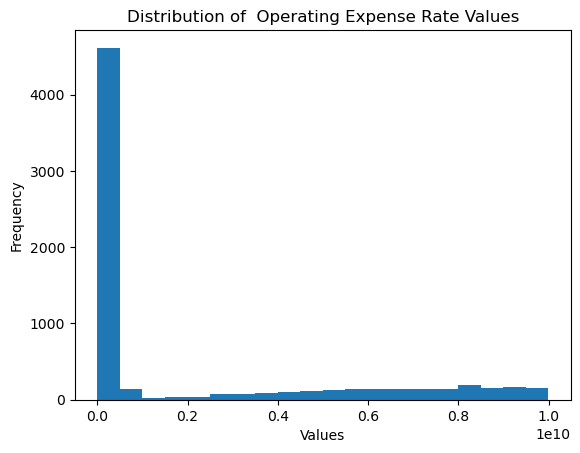

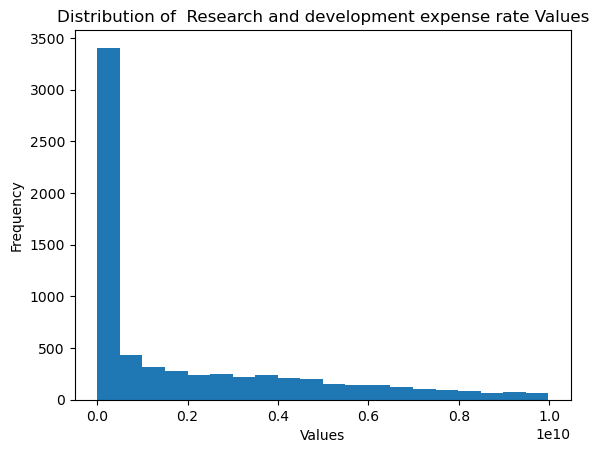

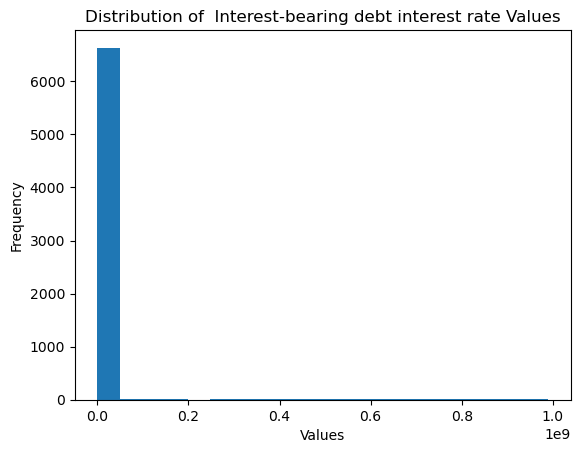

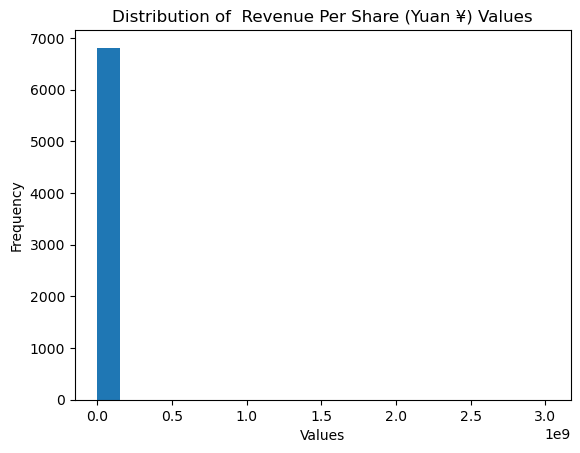

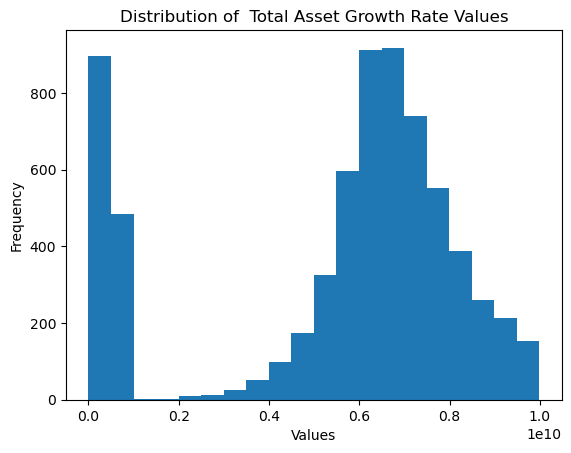

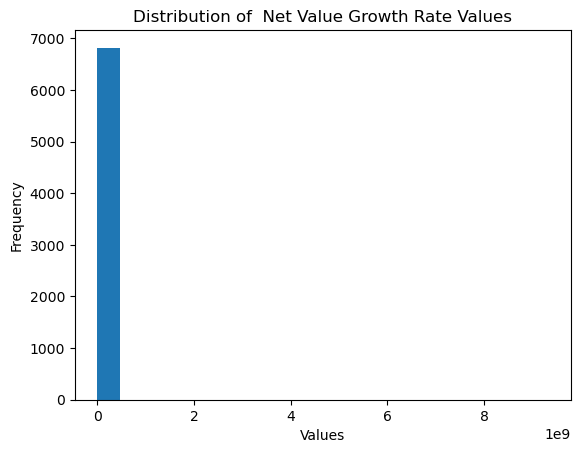

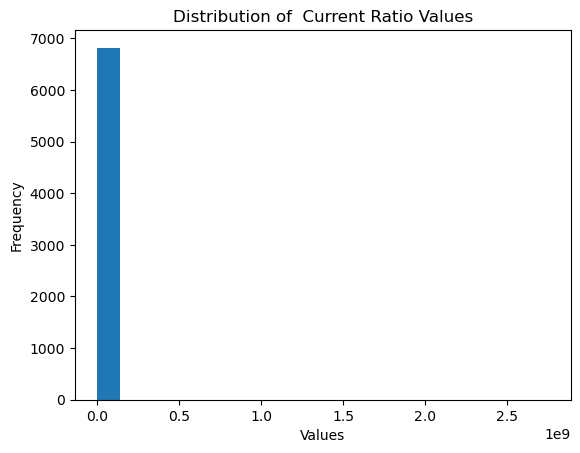

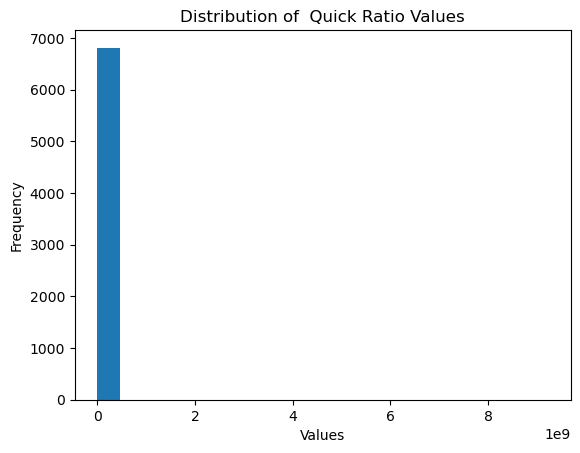

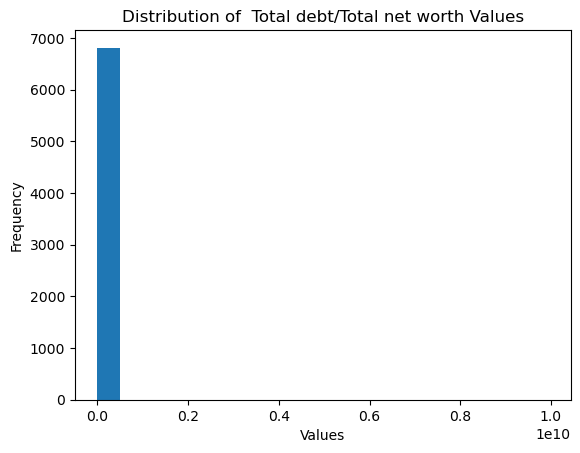

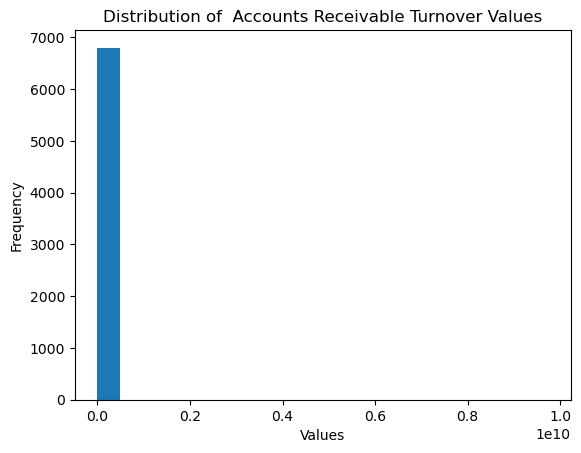

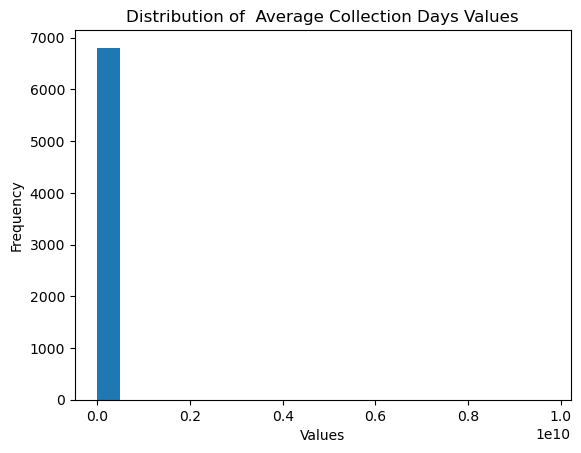

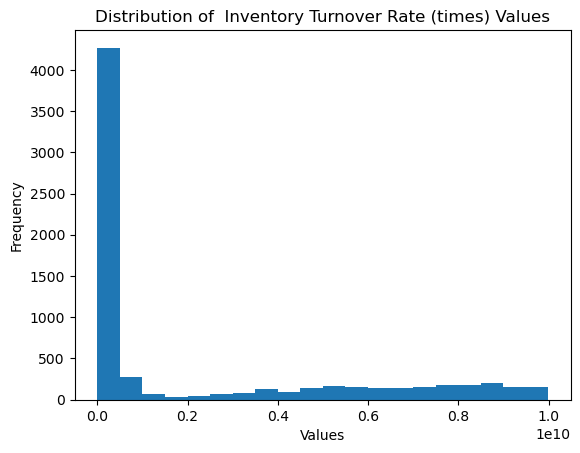

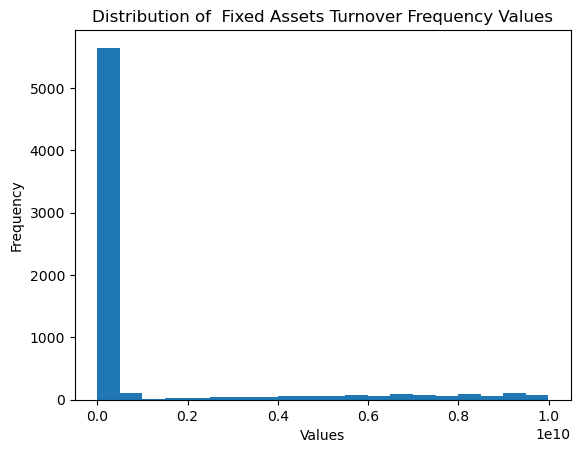

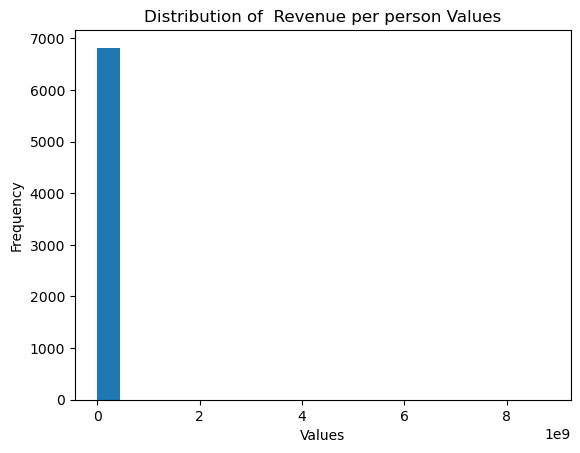

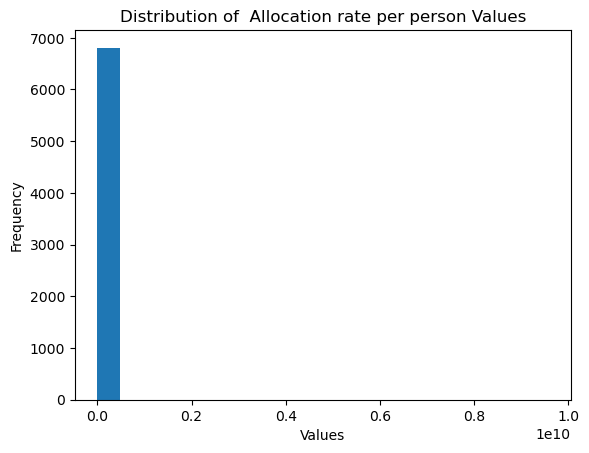

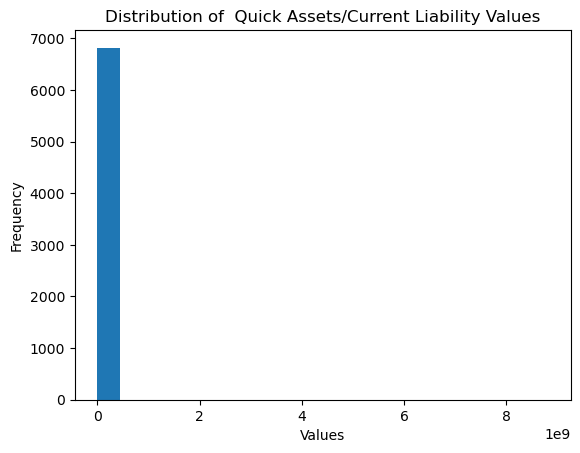

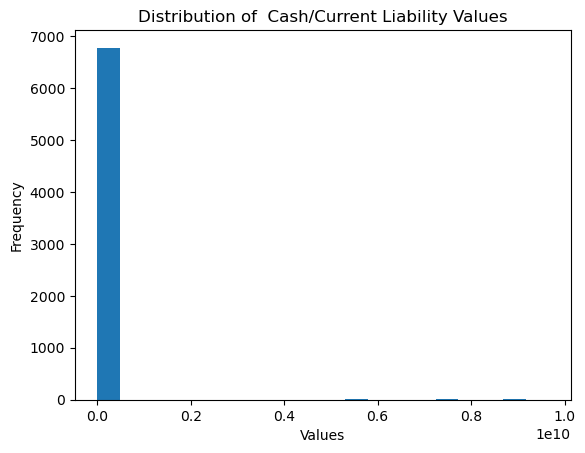

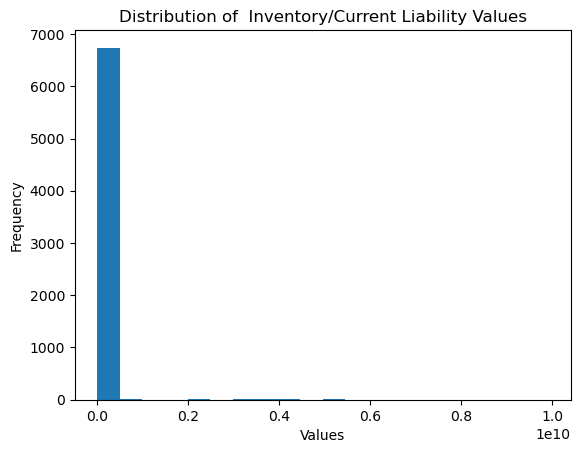

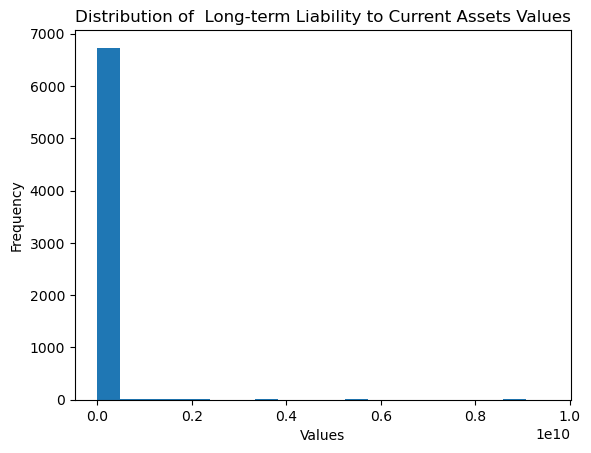

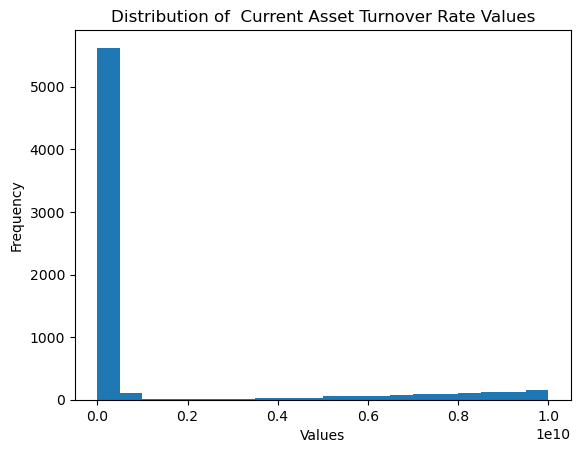

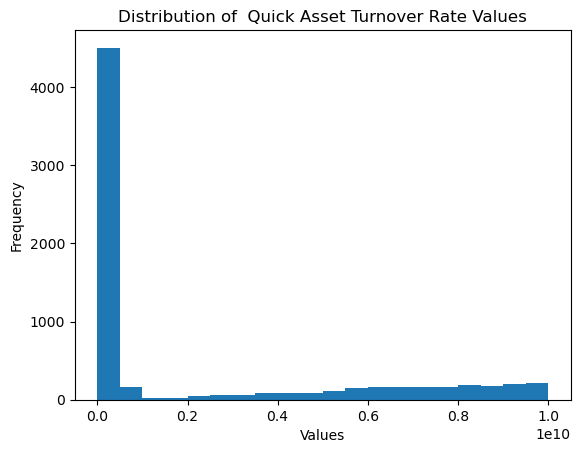

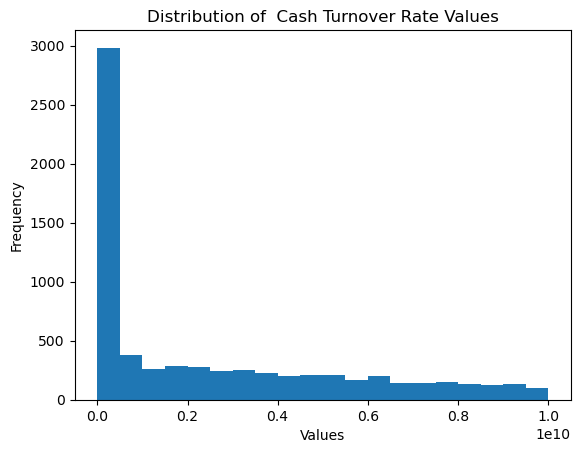

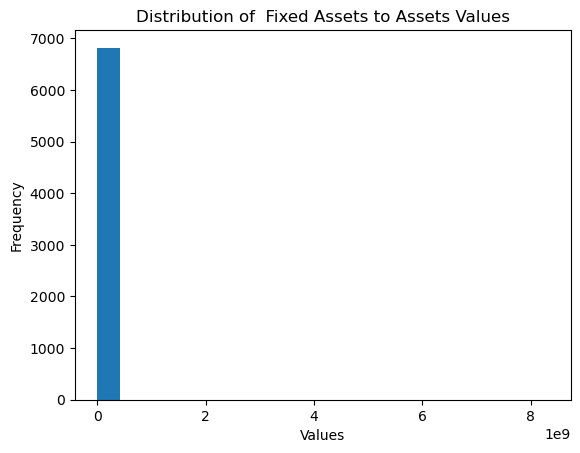

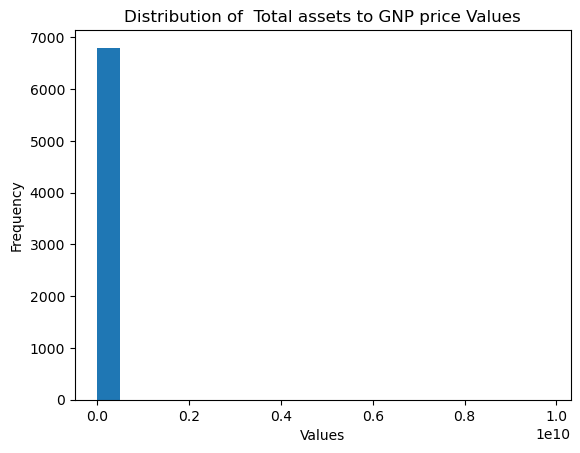

In [8]:
# Checking the value distribution in the colums with high standard deviation

for column in selected_columns:
    distribution(financial_data, column)

Some of the columns look like there is not any error in the data (no outliers), but for some of the feature the distribution is really strange. It looks like all the observation have a value in a specific range, but one (or some) have an extreme high value. I will first remove the ordinal columns from the list and then will explore those with the extreme values.

Several columns appear to have no data errors or outliers, showing seemingly normal distributions. However, certain features show very unusual distribution where most observations fall within a specific range, but one or a few have extremely high values. To address this, I plan to start by excluding the ordinal columns from the ```selected_columns``` list and focus on exploring the rest of the columns.

In [9]:
ordinal_columns = [" Operating Expense Rate", " Research and development expense rate", " Total Asset Growth Rate",\
                   " Inventory Turnover Rate (times)", " Fixed Assets Turnover Frequency", " Current Asset Turnover Rate",\
                   " Quick Asset Turnover Rate", " Cash Turnover Rate"]
selected_columns = list(set(selected_columns) - set(ordinal_columns))

In [10]:
selected_columns

[' Total assets to GNP price',
 ' Cash/Current Liability',
 ' Inventory/Current Liability',
 ' Accounts Receivable Turnover',
 ' Quick Assets/Current Liability',
 ' Revenue per person',
 ' Quick Ratio',
 ' Revenue Per Share (Yuan ¥)',
 ' Interest-bearing debt interest rate',
 ' Net Value Growth Rate',
 ' Long-term Liability to Current Assets',
 ' Fixed Assets to Assets',
 ' Allocation rate per person',
 ' Total debt/Total net worth',
 ' Average Collection Days',
 ' Current Ratio']

In [11]:
for column in selected_columns:
    df = financial_data[financial_data[column]>1000]
    print(f"The feature {column} has {df.shape[0]} values over 1000")

The feature  Total assets to GNP price has 20 values over 1000
The feature  Cash/Current Liability has 46 values over 1000
The feature  Inventory/Current Liability has 99 values over 1000
The feature  Accounts Receivable Turnover has 22 values over 1000
The feature  Quick Assets/Current Liability has 3 values over 1000
The feature  Revenue per person has 2 values over 1000
The feature  Quick Ratio has 9 values over 1000
The feature  Revenue Per Share (Yuan ¥) has 5 values over 1000
The feature  Interest-bearing debt interest rate has 221 values over 1000
The feature  Net Value Growth Rate has 2 values over 1000
The feature  Long-term Liability to Current Assets has 109 values over 1000
The feature  Fixed Assets to Assets has 1 values over 1000
The feature  Allocation rate per person has 12 values over 1000
The feature  Total debt/Total net worth has 8 values over 1000
The feature  Average Collection Days has 18 values over 1000
The feature  Current Ratio has 1 values over 1000


Well, there are maybe about 250-300 unique observations which might be incorrect. I would not remove the whole observations, because I do not want to lose some vital information. For this reason, I will keep my list with selected columns and use it on a later stage to test with and without those features/observations.
The features are in fact not so important in the financial reports and most of them are represented in other features, so even if I remove the columns, the dataset should not have significant information loss.

In [12]:
# Check the correlation between the featudescribe:
financial_data.corr().style.background_gradient(cmap="Greens")

C:\Users\Todor\anaconda3\lib\site-packages\pandas\io\formats\style.py:3555: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\Todor\anaconda3\lib\site-packages\pandas\io\formats\style.py:3556: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [13]:
# Check the distribution of the target column:
financial_data["Bankrupt?"].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

C:\Users\Todor\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


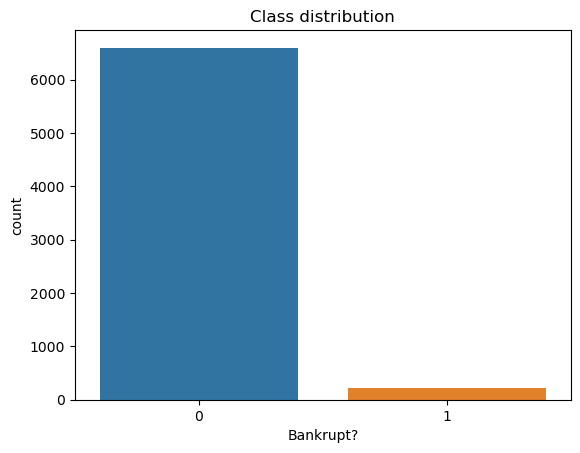

In [14]:
# Visualise the distribution of the target column:
sns.countplot(financial_data["Bankrupt?"])
plt.title("Class distribution")
plt.show()

### Key insights:


- **Data Normalization:** The majority of columns in the dataset show patterns, indicating a data normalization. The reason for this is that the most indicators are kind of a mathematical formula which returns a percentage as a result (between 0 and 1). However, not all columns show these patterns, some of them show ratios and there will be a need for data normalization later. More worrisome is that some of the observations show extreme high ratios which most probably is an error or the data was missing and it was filled with some value. Another possible reason might be that the divisor in the formula was 0 or close to 0 and this resulted in extremely high output.

- **Class Imbalance:** The distribution of the target column (whether a company went into a bankruptcy or not) is highly imbalanced - with only 220 instances of positive cases against 6599 negative cases. For sure, there will be a need to balance the classes with some tecniques so that the future model can successfully catch the minority class.

- **Missing Data:** The dataset is extremely clean, as there are no null values among the features. This will simplifiy the preprocessing steps. One of the issues with the dataset is that it has many features and most of them might not have a significant impact on the prediction for a bankruptcy. I will handle this using some techniques for feature selection.

- **Data Types:** All columns hold numerical values where most of them hold float values and 3 columns (including the target column) hold integer values. This is also a very good sign for a clean dataset and will save us some preprocessing steps.

- **Unique Values:** As expected the values across columns display high variation. However, it's worth to mention that one column, "Net Income Flag", contains the same value (1) for each company and thus does not give us any worthy information so it will be removed in the next phase.

- **Correlation Insights:** The majority of the columns exhibit relatively low correlation with each other. However, certain pairs of columns, such as "ROA" and "Net Income to Total Asset", demonstrate a remarkably strong correlation. Another instance is observed with "Operating Gross Margin" and "Gross Profit to Sales", which exhibit a perfect correlation coefficient of 1. This phenomenon can be attributed to these indicators being calculated from the same underlying mathematical formula. Another interesting think to mention is that Net worth/Assets correlates best with all other features.

## 3. Data Preprocessing and Feature Selection

In this section I will perform the following operations:

**Data Cleaning and Preprocessing:**
- Renaming the columns: so that I can work easier with the features and all the columns have the same name format
- Check whether there are duplicates: I want to remove them if there are any so that the dataset is as clean as possible. I do not want to have any duplicated observations which will bias my model.
- Removing features with no information gain: In this case this is the feature ```Net Income Flag``` as it has only 1 unique value for all the features.
- Data splitting: I will split my dataset into three parts - training dataset, validation dataset and testing dataset. There are in total 6819 observations, so I will use 70% of the dataset for training purposes and 15% for each validation and testing dataset. A split 80:20:20% would also be an option to consider, but one missclassified case would lead to a big decrease in the score. If there are some more target cases to predict this should be more acceptible if the model makes an error. 70% for training is also pretty enough. Of course, more data for training is always an advantage, but in this case I will use the above stated splitting. Furthermore I will activate the random state variable so that the code is reproducible and will split the dataset stratified so that I make sure that every new dataset has its positive and negative cases and that the model can be trained and tested properly.
- Data normalization: so that all the features have a mean of 0 and standard deviation of 1. This will increase the stability of the model, improve its performance and stick to the same scale for all the features.

In [15]:
# Preparing the new column names:
columns_new = list(map(lambda x: x.strip().lower().replace(" ", "_").replace("?", ""), financial_data.columns))
selected_columns = list(map(lambda x: x.strip().lower().replace(" ", "_"), selected_columns))
# Renaming the columns:
financial_data.set_axis(columns_new, axis = 1, inplace = True)
financial_data.head(5)

,bankrupt,roa(c)_before_interest_and_depreciation_before_interest,roa(a)_before_interest_and_%_after_tax,roa(b)_before_interest_and_depreciation_after_tax,operating_gross_margin,realized_sales_gross_margin,operating_profit_rate,pre-tax_net_interest_rate,after-tax_net_interest_rate,non-industry_income_and_expenditure/revenue,continuous_interest_rate_(after_tax),operating_expense_rate,research_and_development_expense_rate,cash_flow_rate,interest-bearing_debt_interest_rate,tax_rate_(a),net_value_per_share_(b),net_value_per_share_(a),net_value_per_share_(c),persistent_eps_in_the_last_four_seasons,cash_flow_per_share,revenue_per_share_(yuan_¥),operating_profit_per_share_(yuan_¥),per_share_net_profit_before_tax_(yuan_¥),realized_sales_gross_profit_growth_rate,operating_profit_growth_rate,after-tax_net_profit_growth_rate,regular_net_profit_growth_rate,continuous_net_profit_growth_rate,total_asset_growth_rate,net_value_growth_rate,total_asset_return_growth_rate_ratio,cash_reinvestment_%,current_ratio,quick_ratio,interest_expense_ratio,total_debt/total_net_worth,debt_ratio_%,net_worth/assets,long-term_fund_suitability_ratio_(a),borrowing_dependency,contingent_liabilities/net_worth,operating_profit/paid-in_capital,net_profit_before_tax/paid-in_capital,inventory_and_accounts_receivable/net_value,total_asset_turnover,accounts_receivable_turnover,average_collection_days,inventory_turnover_rate_(times),fixed_assets_turnover_frequency,net_worth_turnover_rate_(times),revenue_per_person,operating_profit_per_person,allocation_rate_per_person,working_capital_to_total_assets,quick_assets/total_assets,current_assets/total_assets,cash/total_assets,quick_assets/current_liability,cash/current_liability,current_liability_to_assets,operating_funds_to_liability,inventory/working_capital,inventory/current_liability,current_liabilities/liability,working_capital/equity,current_liabilities/equity,long-term_liability_to_current_assets,retained_earnings_to_total_assets,total_income/total_expense,total_expense/assets,current_asset_turnover_rate,quick_asset_turnover_rate,working_capitcal_turnover_rate,cash_turnover_rate,cash_flow_to_sales,fixed_assets_to_assets,current_liability_to_liability,current_liability_to_equity,equity_to_long-term_liability,cash_flow_to_total_assets,cash_flow_to_liability,cfo_to_assets,cash_flow_to_equity,current_liability_to_current_assets,liability-assets_flag,net_income_to_total_assets,total_assets_to_gnp_price,no-credit_interval,gross_profit_to_sales,net_income_to_stockholder's_equity,liability_to_equity,degree_of_financial_leverage_(dfl),interest_coverage_ratio_(interest_expense_to_ebit),net_income_flag,equity_to_liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.00688

In [16]:
# Check for duplicates:
financial_data.duplicated().sum()

0

In [17]:
# Data splitting:
financial_data_attributes = financial_data.drop(columns = ["bankrupt", "net_income_flag"])
financial_data_labels = financial_data["bankrupt"]

financial_data_attributes_selected = financial_data_attributes.drop(columns = selected_columns)

financial_data_outliers_free = drop_rows_by_threshold(financial_data, selected_columns, 1000)
financial_data_attributes_outliers_free = financial_data_outliers_free.drop(columns = ["bankrupt", "net_income_flag"])
financial_data_labels_outliers_free = financial_data_outliers_free["bankrupt"]


# Checking the shapes to confirm:
print(f"The feature columns have the shape:{financial_data_attributes.shape}")
print(f"The target column has the shape:{financial_data_labels.shape}")

print(f"The target column (selected features) has the shape:{financial_data_attributes_selected.shape}")
print(f"The target column (outliers free) has the shape:{financial_data_attributes_outliers_free.shape}")

The feature columns have the shape:(6819, 94)
The target column has the shape:(6819,)
The target column (selected features) has the shape:(6819, 78)
The target column (outliers free) has the shape:(6281, 94)


In [18]:
# Data splitting into train and temporary data:
financial_data_attributes_train, financial_data_attributes_temporary, financial_data_labels_train, financial_data_labels_temporary = \
train_test_split(financial_data_attributes, financial_data_labels, test_size=0.3, random_state=42, stratify=financial_data_labels)

# Data splitting into test and validation data:
financial_data_attributes_val, financial_data_attributes_test, financial_data_labels_val, financial_data_labels_test = \
train_test_split(financial_data_attributes_temporary, financial_data_labels_temporary, test_size=0.5, random_state=42, stratify=financial_data_labels_temporary)

In [19]:
# Data splitting of the selected features into train and temporary data:
financial_data_attributes_selected_train, financial_data_attributes_temporary, financial_data_labels_selected_train, financial_data_labels_temporary = \
train_test_split(financial_data_attributes_selected, financial_data_labels, test_size=0.3, random_state=42, stratify=financial_data_labels)

# Data splitting of the selected features into test and validation data:
financial_data_attributes_selected_val, financial_data_attributes_selected_test, financial_data_labels_selected_val, financial_data_labels_selected_test = \
train_test_split(financial_data_attributes_temporary, financial_data_labels_temporary, test_size=0.5, random_state=42, stratify=financial_data_labels_temporary)

In [20]:
# Data splitting of the into train and temporary data:
financial_data_attributes_outliers_free_train, financial_data_attributes_temporary, financial_data_labels_outliers_free_train, financial_data_labels_temporary = \
train_test_split(financial_data_attributes_outliers_free, financial_data_labels_outliers_free, test_size=0.3, random_state=42, stratify=financial_data_labels_outliers_free)

# Data splitting of the into test and validation data:
financial_data_attributes_outliers_free_val, financial_data_attributes_outliers_free_test, financial_data_labels_outliers_free_val, financial_data_labels_outliers_free_test = \
train_test_split(financial_data_attributes_temporary, financial_data_labels_temporary, test_size=0.5, random_state=42, stratify=financial_data_labels_temporary)

In [21]:
# Data Normalization:
scaler = MinMaxScaler()
financial_data_attributes_train = scaler.fit_transform(financial_data_attributes_train)
financial_data_attributes_val = scaler.fit_transform(financial_data_attributes_val)
financial_data_attributes_test = scaler.fit_transform(financial_data_attributes_test)

# Data Normalization for the selected dataset:
financial_data_attributes_selected_train = scaler.fit_transform(financial_data_attributes_selected_train)
financial_data_attributes_selected_val = scaler.fit_transform(financial_data_attributes_selected_val)
financial_data_attributes_selected_test = scaler.fit_transform(financial_data_attributes_selected_test)

# Data Normalization for the outliers free dataset:
financial_data_attributes_outliers_free_train = scaler.fit_transform(financial_data_attributes_outliers_free_train)
financial_data_attributes_outliers_free_val = scaler.fit_transform(financial_data_attributes_outliers_free_val)
financial_data_attributes_outliers_free_test = scaler.fit_transform(financial_data_attributes_outliers_free_test)

# Checking the shape and the min / max values to confirm:
print(f"The standardized training dataset have the shape:{financial_data_attributes_train.shape}")
print(f"The lowest value after the standardization:{financial_data_attributes_train.min()}")
print(f"The highest value after the standardization:{financial_data_attributes_train.max()}")

print(f"The standardized training dataset (selected features) have the shape:{financial_data_attributes_selected_train.shape}")
print(f"The lowest value after the standardization:{financial_data_attributes_selected_train.min()}")
print(f"The highest value after the standardization:{financial_data_attributes_selected_train.max()}")

print(f"The standardized training dataset (outliers free) have the shape:{financial_data_attributes_outliers_free_train.shape}")
print(f"The lowest value after the standardization:{financial_data_attributes_outliers_free_train.min()}")
print(f"The highest value after the standardization:{financial_data_attributes_outliers_free_train.max()}")

The standardized training dataset have the shape:(4773, 94)
The lowest value after the standardization:0.0
The highest value after the standardization:1.0000000000000002
The standardized training dataset (selected features) have the shape:(4773, 78)
The lowest value after the standardization:0.0
The highest value after the standardization:1.0
The standardized training dataset (outliers free) have the shape:(4396, 94)
The lowest value after the standardization:0.0
The highest value after the standardization:1.0000000000000002


In [22]:
# Double Checking the split according to the shape:

print(f"The shape of the training dataset (features) is: {financial_data_attributes_train.shape}")
print(f"The shape of the training dataset (labels) is: {financial_data_labels_train.shape}")
print(f"The shape of the test dataset (features) is: {financial_data_attributes_test.shape}")
print(f"The shape of the test dataset (labels) is: {financial_data_labels_test.shape}")
print(f"The shape of the validation dataset (features) is: {financial_data_attributes_val.shape}")
print(f"The shape of the validation dataset (labels) is: {financial_data_labels_val.shape}")

The shape of the training dataset (features) is: (4773, 94)
The shape of the training dataset (labels) is: (4773,)
The shape of the test dataset (features) is: (1023, 94)
The shape of the test dataset (labels) is: (1023,)
The shape of the validation dataset (features) is: (1023, 94)
The shape of the validation dataset (labels) is: (1023,)


Well, it looks good, the dataset is now splitted into three parts - training (70%), testing (15%) and validation (15%).

## 4. Model

In this section I will try to create the best possible model optimized to the recall scoring. The process of fine-tuning the model will follow the below stated plan. First I will create my base model, using the Logistic Regression. I am taking the Logistic Regression, because I need a simple and efficient model with which I can optimize my data. A model that is easy to be interpreted and implemented. I will first try to create a model using the whole dataset (with the strange values discussed in the previos sections) and then step by step I will perform different techniqes trying to model the data and make a better model. For example, I will select to remove some features and I will oversample the minority class in order to find the optimal data for this model. Once I have found it, I will implement other models using the best performing training data and will check whether there is a better performing model than the logistic regression. I expect that there is such a model and if this turns out to be true, I will take this model and will further optimize its parameters searching for a better recall score. At the end I will perform the final test using the test data to see what score achieved my model at the end.

4.1 Base Model Selection: 
- Logistic Regression: creating the base model including the parameter grid and the hyperparameters for the model

4.2 Model Training and Hyperparameter Tuning
- Training each model on the training dataset and testing it on the test dataset
- Use of GridSearch (whenever possible) to find the optimal parameters for the model

4.3 Model Evaluation
- For the evaluation of the model performance I will use the recall score. The reason for this is that I want to predict as exact as possible all the companies that will go into bankruptcy. Even if the model predicts some financially healthy companies as "dangerous", it is not such a problem. More important is that the model can wanr me precisely about the companies that will go into bankruptcy.
- Visualisation of the AUC-ROC curve

4.4 Model optimization
- Feature selection and Oversampling: Ocne I have the coefficients and the feature importance from the initial model, I will use techniqes for feature selection and oversampling.

4.5 Model Selection (Pipeline):
- Pipeline with Logistic Regression, Random Forest, Support Vector Machines and AdaBoost.

#### 4.1 Model Selection:
##### Logistic Regression

In [23]:
# Defining the parameters in the grid search:
param_grid = {"C": [0.01, 1, 10, 100, 1000, 2500], "penalty":["l1", "l2"], \
              "solver": ["liblinear","saga"], "class_weight": ["balanced",None], "random_state":[42]}

**Parameters:** I use four parameters for the grid search:
- **C:** I performed multiple tests with many different values aiming to find the best combination for all the parameters. I tried with very small values which I basically prefered for the model so that the model does not overfit the data, but in the end the model needed a higher value for C in order to optimize the recall score.
- **penalty:** For the penalty parameter I take both L1 und L2 as available options for the model, because I am not sure how many features are important. I suggest that few features play key role for the model, but anyway, I wanted to test with both penalties and the model will find its needed penalty.
- **solver:** For the solver parameter I take both "saga" and "liblinear", because they both work with both penaltiy types.
- **class weight:** I gave the model the option to chose between balanced classes and no balance in the classes. The targe variable is very imbalanced and I think that the model will definitely need balanced classes in order to perform good. In other cases I expect extremely low recall score for the targe variable.

In [24]:
# Preparing the grid search for the logistic regression:
logistic_model = LogisticRegression()
stratified_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
grid_search = GridSearchCV(logistic_model, param_grid, cv=stratified_cv, scoring = "recall", verbose = 1)

- **Scoring:** For a scorer I excluded the accuracy score, because for this kind of imbalanced data the model will have over 90% accuracy if it always predict the 0-class. The precision is also not exactly what I need, because it measures out of all positive predictions how many were actually correct. For the purpose of the project I need rather a score that measures the number of the correct predictions out of all the positive cases - which is recall. I accept some missclassifying for the 0-class, meaning that the model predicts some financially healthy companies as potentially bankrupting.

#### 4.2 Model Training

In [25]:
# Fitting the data:
train(grid_search, financial_data_attributes_train, financial_data_labels_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

In [26]:
#Saving the model with pickle
with open("log_reg_starting.pkl", "wb") as file:
    pickle.dump(grid_search.best_estimator_, file)

#### 4.3. Model Evaluation

In [27]:
# Printing the results:
results(grid_search)

Best Parameters: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best Score: 0.8636559139784946


In [28]:
# Testing the model with the validation data + Classification report:
best_model = grid_search.best_estimator_
predictions_logistic_regression = best_model.predict(financial_data_attributes_val)

# Classification report:
print(classification_report(financial_data_labels_val, predictions_logistic_regression))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       990
           1       0.12      0.94      0.21        33

    accuracy                           0.77      1023
   macro avg       0.56      0.85      0.53      1023
weighted avg       0.97      0.77      0.84      1023



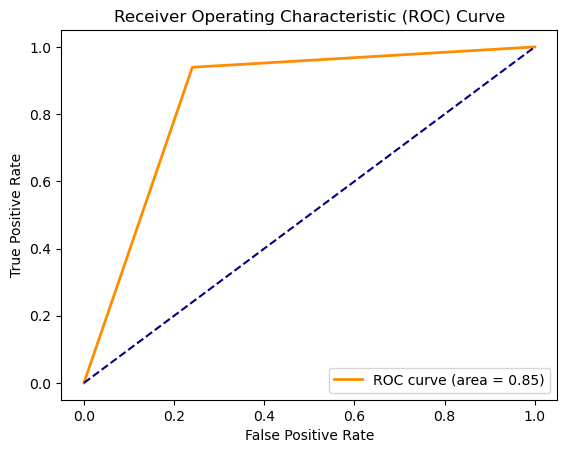

In [29]:
# Calculating and plotting for the ROC-AUC curve:
roc_auc_curve(financial_data_labels_val, predictions_logistic_regression)
roc curve display

##### Conclusions and key insights:

- **Result:** Well the model seems to catch most of the bankrupting companies even if it is not very precise in terms of the positive class. It predicts very often that a company will go into a bankruptcy and the comapny does not. However, as already stated, this is currently not a dramatic issue for the project purpose.

#### 4.4 Model optimization

I will perform couple of operations aiming to improve the performance of my Logistic Regression Model:

4.4.1 Feature Selection:<br>
- Remove the features from the ```selected columns``` list which were identified in section 2 as susceptible.
- Remove the observations with extreme values from the ```selected columns``` list which were identified in section 2 as susceptible.
- Create new variables for the new generated datasets
- Training the Logistic Regression with the new generated datasets
- Evaluating the results

4.4.2 Outliers removal:<br>
- Remove the observations with extreme values from the ```selected columns``` list which were identified in section 2 as susceptible.
- Training the model and evaluation

4.4.3 Class Balancing:<br>
- Use of **Random Oversampling** algorithm to increase the minority class cases
- Training the model and evaluation
- Use of **Class Weighting** algorithm to increase the importance of the minority class
- Training the model and evaluation

##### 4.4.1 Feature selection

In [30]:
# Fitting the data:
train(grid_search, financial_data_attributes_selected_train, financial_data_labels_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

In [31]:
#Saving the model with pickle
with open("log_reg_sfm.pkl", "wb") as file:
    pickle.dump(grid_search.best_estimator_, file)

In [32]:
# Printing the results:
results(grid_search)

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best Score: 0.8705376344086023


In [33]:
# Testing the model with the validation data + Classification report:
best_model = grid_search.best_estimator_
predictions_logistic_regression = best_model.predict(financial_data_attributes_selected_val)

# Classification report:
print(classification_report(financial_data_labels_val, predictions_logistic_regression))

              precision    recall  f1-score   support

           0       0.99      0.80      0.89       990
           1       0.13      0.88      0.22        33

    accuracy                           0.80      1023
   macro avg       0.56      0.84      0.56      1023
weighted avg       0.97      0.80      0.87      1023



Well, the Feature selection did not change that much, but simplified the dataset and reduced its dimensions. The 10% decrease in the recall score for the targe class, however, is too much, so I would prefer to keep the original data.

##### 4.4.2 Outlier removal:

In [34]:
# Fitting the data:
train(grid_search, financial_data_attributes_outliers_free_train, financial_data_labels_outliers_free_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

In [35]:
#Saving the model with pickle
with open("log_reg_outliers_free.pkl", "wb") as file:
    pickle.dump(grid_search.best_estimator_, file)

In [36]:
# Printing the results:
results(grid_search)

Best Parameters: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best Score: 0.9025641025641026


In [37]:
# Testing the model with the validation data + Classification report:
best_model = grid_search.best_estimator_
predictions_logistic_regression = best_model.predict(financial_data_attributes_outliers_free_val)

# Classification report:
print(classification_report(financial_data_labels_outliers_free_val, predictions_logistic_regression))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       914
           1       0.19      0.68      0.29        28

    accuracy                           0.90       942
   macro avg       0.59      0.79      0.62       942
weighted avg       0.97      0.90      0.93       942



Well, obviously the removed observations have important information and contribute positive to the performance of the model. For this reason, I will keep testing with the original data with all features and observations.

##### 4.4.3 Class Weighting:

In [38]:
# Performing the Class weighting technique:
class_weights = compute_class_weight("balanced", classes=[0, 1], y = financial_data_labels_train)

In [39]:
# Fitting the data:
train(grid_search, financial_data_attributes_train, financial_data_labels_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

In [40]:
#Saving the model with pickle
with open("log_reg_class_weighting.pkl", "wb") as file:
    pickle.dump(grid_search.best_estimator_, file)

In [41]:
# Printing the results:
results(grid_search)

Best Parameters: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best Score: 0.8636559139784946


In [42]:
# Testing the model with the validation data + Classification report:
best_model = grid_search.best_estimator_
predictions_logistic_regression = best_model.predict(financial_data_attributes_val)

# Classification report:
print(classification_report(financial_data_labels_val, predictions_logistic_regression))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       990
           1       0.12      0.94      0.21        33

    accuracy                           0.77      1023
   macro avg       0.56      0.85      0.53      1023
weighted avg       0.97      0.77      0.84      1023



##### 4.4.4 Oversampling the minority class:

In [43]:
# Performing the Oversampling of the minority class (50% of the majority class):
oversampler = RandomOverSampler(sampling_strategy = 0.5, random_state = 42)
financial_data_attributes_train_resampled, financial_data_labels_train_resampled = \
oversampler.fit_resample(financial_data_attributes_train, financial_data_labels_train)

In [44]:
# Fitting the data:
train(grid_search, financial_data_attributes_train, financial_data_labels_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

In [45]:
#Saving the model with pickle
with open("log_reg_oversampling.pkl", "wb") as file:
    pickle.dump(grid_search.best_estimator_, file)

In [46]:
# Printing the results:
results(grid_search)

Best Parameters: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 42, 'solver': 'saga'}
Best Score: 0.8636559139784946


In [47]:
# Testing the model with the validation data + Classification report:
best_model = grid_search.best_estimator_
predictions_logistic_regression = best_model.predict(financial_data_attributes_val)

# Classification report:
print(classification_report(financial_data_labels_val, predictions_logistic_regression))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       990
           1       0.12      0.94      0.21        33

    accuracy                           0.77      1023
   macro avg       0.56      0.85      0.53      1023
weighted avg       0.97      0.77      0.84      1023



**Key insights:**

- Feature Selection and Class Balancing (Class weighting and Oversampling): Well, these techniques led to a small increase in the precision for Class 1 and the recall of Class 0 (thus increasing the F1-score for both classes). However, the recall for Class 1 was not influenced and stayed at 94%.: 
- Dimenosionality Reduction: This technique significantly decreased the model performance and the recall for the targeted class was decreased massively.

All these techniques did nto lead to the desired result (increasing the recall score for the targeted class). Some of them even led to worse performance of the model. For this reason I will use the original data attributes

#### 4.5 Model Selection - Pipeline

- Performing the Pipeline using the resampled training dataset

In [48]:
pipeline = Pipeline([("scaler", StandardScaler()),("classifier", None)])
pipeline.set_params(scaler=None)

models = [
    ("Logistic Regression", LogisticRegression(), {"classifier__C": [0.01, 1, 10, 100, 1000, 2500], \
                                                   "classifier__penalty":["l1", "l2"],\
                                                   "classifier__solver": ["liblinear", "saga"],\
                                                   "classifier__random_state":[42],\
                                                   "classifier__class_weight": ["balanced",None]}),
("Random Forest", RandomForestClassifier(),{"classifier__n_estimators": [5, 10, 15, 20],\
                                            "classifier__criterion":["gini", "entropy"],\
                                            "classifier__max_features" : [5, 10, 20, 35, 50],\
                                           "classifier__max_depth": [2, 3, 4, 5, 7],\
                                           "classifier__min_samples_leaf": [5, 10, 15, 30, 50],\
                                           "classifier__class_weight": ["balanced", "balanced_subsample", None],\
                                           "classifier__random_state":[42]}),
    ("SVM_poly", SVC(),{"classifier__C": [0.01, 0.1, 1, 10, 100],\
                   "classifier__kernel": ["poly"],\
                   "classifier__degree": [2,3,5,7],\
                   "classifier__gamma": [0.1, 1, "scale", "auto"],\
                   "classifier__class_weight": ["balanced",None],\
                  "classifier__random_state":[42]}),
        ("SVM", SVC(),{"classifier__C": [0.01, 0.1, 1, 10, 100],\
                   "classifier__kernel": ["rbf", "sigmoid"],\
                   "classifier__gamma": [0.1, 1, "scale", "auto"],\
                   "classifier__class_weight": ["balanced",None],\
                  "classifier__random_state":[42]}),
    ("AdaBoost", AdaBoostClassifier(), {"classifier__n_estimators": [50, 100, 150, 200],\
                                        "classifier__learning_rate": [0.25, 0.5, 0.75, 1, 2],\
                                        "classifier__random_state":[42]})]

**Parameters:**
- **Logistic Regression:** no changes from the earlier stated parameters. The model seems to find a good balance between those parameters and perform very good so far.
- **Random Forest:**
    - n_estimators: I provide in total 4 options for the number of the trees in the forest ranging from 5 to 20 with step 5. A low number of trees in the forest might not be enough to learn the data pattern good, but I also want to avoid overfitting.
    - criterion: For this parameter I give the model the two options ```gini``` and ```entropy```. It should decide based on what information gain should it split.
    - max_features: I will give the model many options here so that it can takes the best one. I will give three numerical values - ```5,10,20, 35, 50```. Setting too low number might lead to underfitting the data and the model will not be able to predict good new data. Setting too high number might lead to overfitting the data. 
    - max_depth: Well, the model has many features, but they are all numerical and very the observations should be classified relatively easy based on 3-5 decision-making processes. However I will give the model the opportunity to find the best option choosing from 5 possible values - ```2,3,4,5,7```. I expect that the model does not need deeper trees to take its decision and on the other sied I would avoid this, because it might lead to overfitting the data.
    - min_samples_leaf: for this parameter I give multiple options ranging from 5 up to 30. I do not want to give too small numbers so that the model overfits and creates trees with 1 sample in each leaf. On the other side too high number for this parameter might skip some patterns of the data, so I want to avoid this as well.
    - class_weight: I give all default options to the model so it can chose the best one based on the data and the structure of the tree. The ```balanced``` option will balance the two classes in the whole dataset, the ```balanced_subsample``` option will balance the two classes in each tree and the ```None``` option is also available in case the model does not need balancing of the classes, but in this case of extremely imbalanced classes I do not think that this option will be used for training a good model.
    - random state: The only option for this parameter is the integer ```42``` so that the code can be reproducible.

- **SVM:**
    - C:I will give here values in the range of 0.01 up to 100. A lower C might lead to underfitting the data and a higher value might lead to overfitting the data.
    - kernel: I will use the ```poly``` option and will give the model couple of degrees in order to chose the best one. The other model will try with the other kernels and I will remove the ```degree``` parameter from the param grid.
    - degree: The range for the degrees is ```2,3,5,7```. Most probably the model will take the highest possible degree and will overfit the data, which will lead to a lower score when using new (unseen) data. However, I should give it a try.
    - gamma: I will give the model to chose between 2 numerical values - ```0.1``` and ```1``` and two default options - ```auto``` and ```scale```. I would not give the model any lower or higher numerical values, because this might lead to under-/overfitting.
    - class_weight: I give both default options - ```balanced``` and ```None``` - to the model so it can chose the best one based on the data and the structure of the tree. The ```balanced``` option will balance the two classes in the whole dataset and the ```None``` option is also available in case the model does not need balancing of the classes, but in this case of extremely imbalanced classes I do not think that this option will be used for training a good model.
    - random_state: The only option for this parameter is the integer ```42``` so that the code can be reproducible.
    
- **AdaBoostClassifier:**
    - n_estimators: The number of the decision trees should not be too much, because the model will get too complex and might overfit. However, I will put 4 values - ```50, 100, 150, 200```. A lower value than that might be a little bit too low for creating a good model, because the tree will not have enough ittreation to learn from the previos mistakes.
    - learning_rate: I give here again rich choice for the algorithm - ```0.25, 0.5, 0.75, 1, 2```. The default value for the model is 1, but I want to test with couple of values that are smaller than 1 and with one value bigger than 1. However, a higher value for learning rate might lead to an overfitting, so I would not give any bigger values for this parameter.
    - random_state: The only option for this parameter is the integer ```42``` so that the code can be reproducible.

In [49]:
best_models = {}

    #Fitting the models using the normal data without manipulations:
for name, model, param_grid in models:
    pipeline.set_params(classifier=model)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring = "recall")
    grid_search.fit(financial_data_attributes_train, financial_data_labels_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    #Printing the best parameters:
    print(f"{name} - Best Parameters: {best_params}, Best Score: {best_score}")
    
    # Testing the model with the validation data:
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(financial_data_attributes_val)

    # Classification report:
    print(classification_report(financial_data_labels_val, predictions))
    
    # Save the best model to a dictionary
    best_models[name] = best_model
    
    # Save the best models using pickle
    for name, model in best_models.items():
        with open(f"best_model_pipeline_{name}.pkl", "wb") as file:
            pickle.dump(model, file)

C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

Logistic Regression - Best Parameters: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__random_state': 42, 'classifier__solver': 'saga'}, Best Score: 0.9161290322580644
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       990
           1       0.12      0.94      0.21        33

    accuracy                           0.77      1023
   macro avg       0.56      0.85      0.53      1023
weighted avg       0.97      0.77      0.84      1023

Random Forest - Best Parameters: {'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__max_features': 5, 'classifier__min_samples_leaf': 50, 'classifier__n_estimators': 5, 'classifier__random_state': 42}, Best Score: 0.8638709677419355
              precision    recall  f1-score   support

           0       1.00      0.15      0.25       990
           1       0.04      1.00

C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM - Best Parameters: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.1, 'classifier__kernel': 'sigmoid', 'classifier__random_state': 42}, Best Score: 1.0


C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98       990
           1       0.00      0.00      0.00        33

    accuracy                           0.97      1023
   macro avg       0.48      0.50      0.49      1023
weighted avg       0.94      0.97      0.95      1023

AdaBoost - Best Parameters: {'classifier__learning_rate': 2, 'classifier__n_estimators': 100, 'classifier__random_state': 42}, Best Score: 0.5978494623655914
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       990
           1       0.14      0.33      0.20        33

    accuracy                           0.91      1023
   macro avg       0.56      0.63      0.57      1023
weighted avg       0.95      0.91      0.93      1023



In [50]:
best_models_feature_selection = {}

    #Fitting the models using the selected features only:
for name, model, param_grid in models:
    pipeline.set_params(classifier=model)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring = "recall")
    grid_search.fit(financial_data_attributes_selected_train, financial_data_labels_selected_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    #Printing the best parameters:
    print(f"{name} - Best Parameters: {best_params}, Best Score: {best_score}")
    
    # Testing the model with the validation data:
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(financial_data_attributes_selected_val)

    # Classification report:
    print(f"The classification report for {name}:")
    print(classification_report(financial_data_labels_selected_val, predictions))
    
    # Save the best model to a dictionary
    best_models_feature_selection[name] = best_model
    
    # Save the best models using pickle
    for name, model in best_models_feature_selection.items():
        with open(f"best_model_pipeline_feature_selection_{name}.pkl", "wb") as file:
            pickle.dump(model, file)

C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

Logistic Regression - Best Parameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__random_state': 42, 'classifier__solver': 'saga'}, Best Score: 0.9156989247311828
The classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.69      0.82       990
           1       0.09      0.97      0.17        33

    accuracy                           0.70      1023
   macro avg       0.55      0.83      0.49      1023
weighted avg       0.97      0.70      0.79      1023

Random Forest - Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__max_features': 5, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 10, 'classifier__random_state': 42}, Best Score: 0.8567741935483871
The classification report for Random Forest:
              precision    recall  f1-score   support

  

C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM - Best Parameters: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.1, 'classifier__kernel': 'sigmoid', 'classifier__random_state': 42}, Best Score: 1.0
The classification report for SVM:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       990
           1       0.00      0.00      0.00        33

    accuracy                           0.97      1023
   macro avg       0.48      0.50      0.49      1023
weighted avg       0.94      0.97      0.95      1023



C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AdaBoost - Best Parameters: {'classifier__learning_rate': 2, 'classifier__n_estimators': 100, 'classifier__random_state': 42}, Best Score: 0.5849462365591398
The classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       990
           1       0.14      0.33      0.20        33

    accuracy                           0.91      1023
   macro avg       0.56      0.63      0.57      1023
weighted avg       0.95      0.91      0.93      1023



In [51]:
best_models_outlier_removal = {}

    #Fitting the models using the outliers free data:
for name, model, param_grid in models:
    pipeline.set_params(classifier=model)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring = "recall")
    grid_search.fit(financial_data_attributes_outliers_free_train, financial_data_labels_outliers_free_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    #Printing the best parameters:
    print(f"{name} - Best Parameters: {best_params}, Best Score: {best_score}")
    
    # Testing the model with the validation data:
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(financial_data_attributes_outliers_free_val)

    # Classification report:
    print(f"The classification report for {name}:")
    print(classification_report(financial_data_labels_outliers_free_val, predictions))
    
    # Save the best model to a dictionary
    best_models_outlier_removal[name] = best_model
    
    # Save the best models using pickle
    for name, model in best_models_outlier_removal.items():
        with open(f"best_model_pipeline_outlier_removal{name}.pkl", "wb") as file:
            pickle.dump(model, file)

C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter 

Logistic Regression - Best Parameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__random_state': 42, 'classifier__solver': 'saga'}, Best Score: 0.8883190883190883
The classification report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       914
           1       0.13      0.89      0.23        28

    accuracy                           0.82       942
   macro avg       0.56      0.86      0.57       942
weighted avg       0.97      0.82      0.88       942

Random Forest - Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 'classifier__max_features': 5, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 5, 'classifier__random_state': 42}, Best Score: 0.805982905982906
The classification report for Random Forest:
              precision    recall  f1-score   support

 

C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM - Best Parameters: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.1, 'classifier__kernel': 'sigmoid', 'classifier__random_state': 42}, Best Score: 1.0
The classification report for SVM:


C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Todor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       914
           1       0.03      1.00      0.06        28

    accuracy                           0.03       942
   macro avg       0.01      0.50      0.03       942
weighted avg       0.00      0.03      0.00       942

AdaBoost - Best Parameters: {'classifier__learning_rate': 2, 'classifier__n_estimators': 100, 'classifier__random_state': 42}, Best Score: 0.7253561253561254
The classification report for AdaBoost:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       914
           1       0.03      0.04      0.03        28

    accuracy                           0.94       942
   macro avg       0.50      0.50      0.50       942
weighted avg       0.94      0.94      0.94       942



**Key Insights:**

- Logistic Regression: 
    - Very good results at all and in terms of recall score for the target class - 94% on the validation datataset.
    - Very low precision, meaning that the model predicts the target class much more often in order to catch all the positive cases and thus generates a lot of mistakes.
    - Interestingly the training model showed 91% recall, lower than on the validation set. There are only 33 positive cases in the validation set, so it definitely predicted much more often the positive class in order to catch all cases and this resulted in a extremely low precision.
- Random Forest:
    - Very interesting results from the random forest. Not a bad performance at all, but quiet different depending on the data. Looking at the second scenario - selected features data - the model performed surprisingly good. It could predict both classes verz good, catched some patterns and has very high recall score for the target class without loosing too much from the recall for the 0-class. The unmanipulated data showed also good results predicting the target class, but the model had very low recall score for the 0-class meaning the model predicts mainly the target class ad can not differentiate good enough between both classes. The performance of the model using the outlier free data is dissappointing. Main reason fot his might be that the dropped observations were valuable for the model building.
- SVM:
    - Both SVC model used for each dataset could not perform satisfactorily. They showed perfect score of 100% recall on the training dataset, but failed to predict even 1 case of the target class correctly when the model was tested on the validation dataset. The models used 2-nd degree of polynomial regression which in my opinion is too simple model for this kind of data. The other SVC model could find also another appropriate solution using the other kernel types and also failed. Looking at the outlier free data, the model scored 100% recall for the target class, but 0% on the other one, so this could not be classified as a success for the model.
- AdaBoost:
     - AdaBoost manages to predict pretty good the 0-class, but failes predicting the targe class. It scores much better on the training dataset, but fails to generalise and scores much worse on the validation dataset. It looks like the model could try to improve its performance increasing the learning rate, but on the other side this might lead to overfitting to the data.
     - The reason for the low performance might be the highly imbalanced classes. The other algorithmes have a hyperparameter for class weighting, but the AdaBoost does not. Well, there is an option to use it as a parameter which can be a further optimization idea for a futuer work.

Looking at the different datasets used in the Pipeline:

- Unmanipulated data - using the datasets without manipulations showed good and stable result. 
- Selected features data - The Logistig Regression and the Random Forest showed very good performance using this dataset. The Random forest increased significantly the recall score for the 0-class in comparison to the unmanipulated data. However, this can be explained as there were removed couple of features that had extreme values.
- Outlier free data - This dataset showed the worst results. It looks like the "outliers" were important for the dataset and should not be removed.
     
### 5. Model Comparison and Selection

Among the four models I have two favourite models that I would like to test with the testing data.
- Unmanipulated Data - I will take definitely the logistic regression which differentiate between the two classes and shows very nice recall score for both of them.
- Selected Feature Data - I would like to test the Random forest variation. It showed very nice results on the validation dataset and looks promising.

In [52]:
with open("best_model_pipeline_Logistic Regression.pkl", "rb") as file:
    best_logistic_regression = pickle.load(file)
    
with open("best_model_pipeline_feature_selection_Random Forest.pkl", "rb") as file_2:
    best_random_forest = pickle.load(file_2)

## 6. Final Model Testing

In [53]:
# Testing the model with the validation data:
predictions_logistic_regression = best_logistic_regression.predict(financial_data_attributes_test)

# Classification report:
print(classification_report(financial_data_labels_test, predictions_logistic_regression))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       990
           1       0.18      0.64      0.28        33

    accuracy                           0.89      1023
   macro avg       0.58      0.77      0.61      1023
weighted avg       0.96      0.89      0.92      1023



In [54]:
# Testing the model with the validation data:
predictions_logistic_regression_2 = best_random_forest.predict(financial_data_attributes_selected_test)

# Classification report:
print(classification_report(financial_data_labels_selected_test, predictions_logistic_regression_2))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       990
           1       0.17      0.58      0.26        33

    accuracy                           0.89      1023
   macro avg       0.57      0.74      0.60      1023
weighted avg       0.96      0.89      0.92      1023



## 7. Final Thoughts and Future Work

**Key Takeaways:**

- Predictive Accuracy: The model does a great job when it comes to predicting the companies which will not bankrupt. Looking at the interesting class however, the model has a good performance, but not optimal. About 60% is a good result if we consider the highly imbalanced data, the suspect of outliers and the multiple features included in the model.
- The logistic regression model dominates showing better recall and precision score in comparison to the random forest model (with selected features data). This means that this logistic regression model can be further optimized for still better performance as a future work.

**Future Work:**

- Feature Engineering: There are other factors which can lead to (or force) a company to go into bankruptcy that are not consiered in this project. Financial crisis and wars are just some examples which can lead to an immediate bankruptcy. Thus, the model could not foresee this, because the financial data might have been very good for the last year, but global factors like this can have an immediate effect.

- Imbalanced Data Handling: Investigate advanced techniques for handling imbalanced datasets, as the class imbalance between bankrupt and non-bankrupt companies might affect model generalization. In this project I oversampled the minority class, but this is of course not the best solution.

- Scoring: Another scoring might be considered e.g fbeta score (formula below).

- More complicated models: There is of course a lot of free space for testing the data with more complicated models and more parameters. 

- Data Manipulation: The data in this project has been preprocessed and cleaned, but there is still free space for further manipulation, feature selection, feature engineering etc.

By addressing these areas, the model's accuracy and stability in predicting company bankruptcy can be further improved, ensuring its reliability in the financial decision-making processes.

All of the above mentioned points can significantly further improve the models performance and stability. Depending on the purpose of the model, the data can be further manipulated (incl. new data can be gathered) so that the model has more capability to learn.

In [55]:
# Define a custom scoring function using F-beta score
def custom_fbeta_score(y_true, y_pred):
    beta = 5
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Create the scorer
scorer = make_scorer(custom_fbeta_score)